In [1]:
# https://www.kaggle.com/code/alekseytrepetsky/create-chemberta-embed

from IPython.display import clear_output as clr
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import seaborn as sns
from transformers import AutoModelForMaskedLM, AutoTokenizer

chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
chemberta.eval()

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(600, 384, padding_idx=1)
      (position_embeddings): Embedding(515, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.144, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-2): 3 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.109, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): 

In [3]:
def featurize_ChemBERTa(smiles_list, padding=True):
    embeddings_cls = torch.zeros(len(smiles_list), 600)
    embeddings_mean = torch.zeros(len(smiles_list), 600)

    with torch.no_grad():
        for i, smiles in enumerate(tqdm(smiles_list)):
            encoded_input = tokenizer(smiles, return_tensors="pt", padding=padding, truncation=True)
            model_output = chemberta(**encoded_input)
            
            embedding = model_output[0][::,0,::]
            embeddings_cls[i] = embedding
            
            embedding = torch.mean(model_output[0],1)
            embeddings_mean[i] = embedding
            
    return embeddings_cls, embeddings_mean

In [4]:
df_de_train = pd.read_parquet('../../data/de_train.parquet')

In [5]:
df_compound = df_de_train[['sm_name', 'SMILES']].drop_duplicates()

In [6]:
df_compound

,sm_name,SMILES
0,Clotrimazole,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
4,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...
8,Idelalisib,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...
14,Vandetanib,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
18,Bosutinib,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...
...,...,...
594,CGM-097,COc1cc2c(cc1OC(C)C)[C@H](c1ccc(Cl)cc1)N(c1ccc(...
598,TGX 221,Cc1cc(C(C)Nc2ccccc2)c2nc(N3CCOCC3)cc(=O)n2c1
602,Azacitidine,Nc1ncn([C@@H]2O[C@H](CO)[C@@H](O)[C@H]2O)c(=O)n1
606,Atorvastatin,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...


In [7]:
embeddings_cls, embeddings_mean = featurize_ChemBERTa(df_compound.SMILES)

100%|██████████| 146/146 [00:01<00:00, 141.53it/s]


In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)

In [9]:
embeddings_mean_pca = pca.fit_transform(embeddings_mean)

In [10]:
np.min(embeddings_mean_pca)

-15.465112428866865

In [11]:
pca.explained_variance_ratio_

array([0.20413661, 0.16370424, 0.13984939, 0.07466608, 0.06111542,
       0.04910357, 0.03278679, 0.03122109, 0.02557054, 0.02396493,
       0.02077645, 0.02010264, 0.01862478, 0.0164721 , 0.01354135,
       0.01310717, 0.01047042, 0.00946308, 0.00824114, 0.0078797 ,
       0.00687123, 0.0064571 , 0.00531966, 0.00501186, 0.0036676 ,
       0.00314963, 0.00241343, 0.00216725, 0.00171578, 0.00122484])

In [12]:
df_embedding = pd.DataFrame(embeddings_mean_pca, columns=['ChemBERTa_' + str(i) for i in range(30)])
df_embedding['sm_name'] = df_compound['sm_name'].values
df_embedding['SMILES'] = df_compound['SMILES'].values

In [13]:
df_embedding.head()

,ChemBERTa_0,ChemBERTa_1,ChemBERTa_2,ChemBERTa_3,ChemBERTa_4,ChemBERTa_5,ChemBERTa_6,ChemBERTa_7,ChemBERTa_8,ChemBERTa_9,...,ChemBERTa_22,ChemBERTa_23,ChemBERTa_24,ChemBERTa_25,ChemBERTa_26,ChemBERTa_27,ChemBERTa_28,ChemBERTa_29,sm_name,SMILES
0,3.179919,-4.687706,-4.623246,1.254814,5.282465,2.970388,-0.237230,1.332898,1.294285,2.811361,...,-2.919976,-0.244050,0.865697,-0.010480,-0.303170,-0.965435,0.784266,0.361582,Clotrimazole,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
1,7.451252,0.383750,1.268539,7.552625,-1.523159,-0.082724,-2.609739,1.288590,2.002610,6.674026,...,1.402683,-0.243014,-0.378355,-0.847325,-0.024457,-0.493676,-0.507556,0.204738,Mometasone Furoate,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...
2,-4.496194,5.499674,2.434648,-1.057762,-2.068403,-0.727420,-0.966918,2.025422,2.593186,1.352790,...,-1.514117,-0.516745,0.969760,0.974318,0.495002,-0.792707,0.563062,0.246157,Idelalisib,CC[C@H](Nc1ncnc2[nH]cnc12)c1nc2cccc(F)c2c(=O)n...
3,-6.795396,-5.836981,4.484647,-3.136359,-0.792571,3.269678,-2.416987,1.076718,-0.219331,-0.389973,...,-0.172608,0.259540,0.601946,-1.127668,0.246147,-0.332707,-0.103326,-0.253317,Vandetanib,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1
4,2.275002,-8.121044,-0.387577,-5.903578,-0.573389,3.516201,-2.809049,0.645430,2.345354,-2.769624,...,-0.253444,0.420494,-0.422652,0.494291,-0.091421,1.653005,0.973916,-0.829430,Bosutinib,COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC)cc...


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/zl_scp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/zl_scp/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='ChemBERTa_0', ylabel='ChemBERTa_1'>

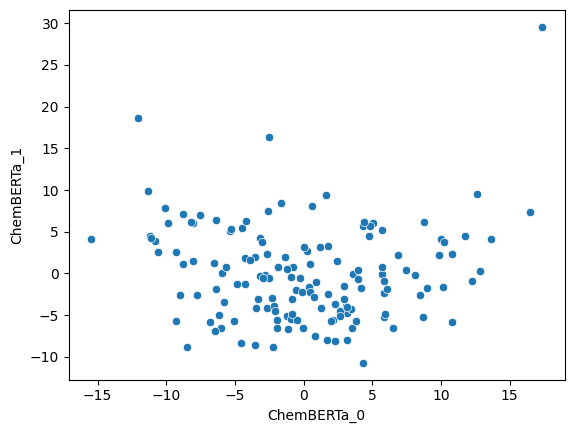

In [14]:
sns.scatterplot(df_embedding, x='ChemBERTa_0', y='ChemBERTa_1')

In [15]:
df_embedding.to_csv('../../results/ChemBERTa-77M-MTR/df_embedding.csv')